<u><h1 style="text-align:center">DSIP Final Project Part 2-ML</h1></u>
<h4 style="text-align:center">Ofek Shemesh 313559601, Uri Zaslavski 315683748</h4>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

# <u>Part 1: Data Engineering</u>

# Q6: Division of data to train and test

In [2]:
Data = pd.read_csv("data.csv")

#### Data manipulations

In [3]:
Data["Transported"] = Data["Transported"].astype(int) #Transform Y to 0 or 1
Data["VIP"] = Data["VIP"].fillna(0) #If they were VIP they would't forget to write it
Data["VIP"] = Data["VIP"].astype(int)

# No one forgets when money is involved
Data["RoomService"] = Data["RoomService"].fillna(0)
Data["FoodCourt"] = Data["FoodCourt"].fillna(0)
Data["ShoppingMall"] = Data["ShoppingMall"].fillna(0)
Data["Spa"] = Data["Spa"].fillna(0)
Data["VRDeck"] = Data["VRDeck"].fillna(0)

# You can't spend money while cryo sleeping
conditionYes = (Data["RoomService"] == 0) & (Data["FoodCourt"] == 0) \
& (Data["ShoppingMall"] == 0) & (Data["Spa"] == 0) & (Data["VRDeck"] == 0)
conditionNo = (Data["RoomService"] != 0) | (Data["FoodCourt"] != 0) \
| (Data["ShoppingMall"] != 0) | (Data["Spa"] != 0) | (Data["VRDeck"] != 0)
Data.loc[conditionYes, "CryoSleep"] = Data.loc[conditionYes, "CryoSleep"].fillna(1)
Data.loc[conditionNo, "CryoSleep"] = Data.loc[conditionNo, "CryoSleep"].fillna(0)
Data["CryoSleep"] = Data["CryoSleep"].astype(int)

# Divide Cabin column into 3 seperate columns
Data[["Deck", "Cabin_num", "Side"]] = Data["Cabin"].str.split("/", expand=True)
Data = Data.drop("Cabin", axis=1) # Finished proccessing Cabin
Data = Data.drop("Name", axis=1) # Name is irrelevant, no identifying details for class or status

# Map deck letters to numbers
Deck_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H" : 8, "I" : 9, "J" : 10,\
               "K" : 11, "L" : 12, "M" : 13, "N" : 14, "O" : 15, "P" : 16, "Q" : 17, "R" : 18, "S" : 19,\
                "T" : 20, "U" : 21, "V" : 22, "W" : 23, "X" : 24, "Y" : 25, "Z" : 26}
Data['Deck'] = Data['Deck'].map(Deck_mapping)

# Map side to numbers
Side_mapping = {"P" : 1, "S" : 2}
Data['Side'] = Data['Side'].map(Side_mapping)

# Set missing age to average
Data["Age"] = Data["Age"].fillna(Data["Age"].mean())

# Split ID into group number and id in the group
Data[["Group", "IdInGroup"]] = Data["PassengerId"].str.split('_', expand=True)
Data[["Group", "IdInGroup"]] = Data[["Group", "IdInGroup"]].astype(int)
# Create new column indicating the number of people in a passenger's group
Data["GroupSize"] = Data.groupby('Group')['IdInGroup'].transform('size')
Data.drop("Group", axis=1, inplace=True)
Data.drop("IdInGroup", axis=1, inplace=True)
Data.drop("PassengerId", axis=1, inplace=True)

# Add a column stating if the passenger is underage
Data["Underage"] = np.where(Data["Age"] < 18, 1, 0)

# Drop home planet and destination from the dataframe
Data.drop(["HomePlanet", "Destination"], axis=1, inplace=True)

# If no info about cabin, drop entry from Data
Data.dropna(subset=['Cabin_num'], axis=0, inplace=True)
#Data.reset_index(drop=True, inplace=True)
Data["Cabin_num"] = Data["Cabin_num"].astype(int)

In [4]:
# Splitting the data into 2/3 train and 1/3 test so train is double the size of test
cutoffPoint = np.round(len(Data)/3*2).astype(int)
Xtrain = Data.drop("Transported", axis=1).loc[:cutoffPoint].to_numpy()
Ytrain = Data["Transported"].loc[:cutoffPoint].to_numpy()
Xtest = Data.drop("Transported", axis=1).loc[cutoffPoint:].to_numpy()
Ytest = Data["Transported"].loc[cutoffPoint:].to_numpy()

# Q7:

#### First we converted every column with a True/False value to 1/0 for later ease of use.
### <u>Dealing with NaN or Null values:</u>
#### For VIP we put 0, most people are not VIP so chances are good they are in fact not a VIP if it was not stated.
#### Bills (Room service, Food court, Shopping mall, Spa and VR deck) were also filled with 0 because it's very unlikely that if money was spent someone didn't record it.
#### CryoSleep is a not as simple, we assumed that if someone is in Cryo Sleep (which means they are confined to their room) then they are unable to spend any money on their voyage, so we looked at their spendings and decided that if the total bill is 0 they are likely sleeping, but if they spent any money it probaly means they are awake and not in Cryo Sleep state.
### <u>Creating new columns:</u>
#### Breaking down Cabin into 3 separate columns: "Deck", "Cabin_Num", "Side",  and mapping Deck and Side from letters to. numbers that can be used later, this way we can transform the information in "Cabin" into meaningful data that is useable, Cabin was then dropped
#### Passenger_ID was first broken into "Group" and "ID in group" so we could count the number of people in the group and create a new column "GroupSize" which indicates if the person was traveling alone or in a group, and how big is that group, "Passenger_ID", "Group" and "ID in group" were then dropped.
#### "Underage" column was created, and in it 1 if the passenger's age is under 18 years old and 0 if they are at least 18.
### <u>Dropping other irrelevant data:</u>
#### Name does't contain any useful info about the person's status or class.
#### HomePlanet and Destination were also dropped because they have no bearing on anything useful at the time of the incident.
#### Any passenger that did not have any info about Cabin was dropped from the data because after the seperation of Cabin, this is 3 columns that are completely missing, which can be important information and cannot be guessed by us.

# <u>Part 2: KNN</u>

# Q8:

### a:
#### Build the KNN classifier

In [5]:
def KNN(K, Xtrain, Ytrain, Xclassify):
    d = []
    classes = [[0, 1], [0, 0]] # Classess, 1-Yes 0-No with counter 0 for both initially
    d = np.linalg.norm(Xclassify - Xtrain, axis=1) # Return distances of Xclassify point from all other points in Xtrain
    d = np.column_stack((d, Ytrain)) # Sticking together distance and true classification as a row for each point
    d = d[d[:, 0].argsort()] # Sorting rows by distance
    d = d[:K] # Clipping after the first K rows (we don't need the rest)
    # Count how many of each group are in the K elements left in d
    for n in range(len(classes)):
        classes[n][0] = d[d[:, 1] == classes[n][1]].size
    classes.sort(reverse=True) # Sort counters by reverse order to find the bigger one and returning its label
    return classes[0][1]

#### Classify a dataset of points

In [6]:
def KNNset(K, Xtrain, Ytrain, Xset):
    Ypredicted = []
    for n in range(Xset.shape[0]):
        Ypredicted.append(KNN(K, Xtrain, Ytrain, Xset[n]))
    return Ypredicted

#### Build accuracy function

In [7]:
def Accuracy(Ypredicted, Ytest):
    return np.array(np.where(Ytest == Ypredicted)).size / Ytest.size

#### Calculate and output accuracy for the classifier with K = 3

In [8]:
K = 3
YPredicted = KNNset(K, Xtrain, Ytrain, Xtrain)
TrainAccuracy = Accuracy(YPredicted, Ytrain)
YPredicted = KNNset(K, Xtrain, Ytrain, Xtest)
TestAccuracy = Accuracy(YPredicted, Ytest)

#### Accuracy for each data set with K = 3

In [9]:
print("Train Accuracy: " + str(TrainAccuracy))
print("Test Accuracy: " + str(TestAccuracy))

Train Accuracy: 0.8563155989866088
Test Accuracy: 0.7585045469855171


#### b:
#### Test different K values to find the optimal K

#### Plot the results to find the optimal K value

In [10]:
def PlotK(maxK, TrainAccuracy, TestAccuracy):
    K = list(range(1, maxK+1, 2))
    plt.figure(figsize=(8, 8))
    plt.title('KNN accuracy for K = 1 - '+ str(maxK))
    plt.plot(K, TrainAccuracy, "b")
    plt.plot(K, TestAccuracy, "r")
    plt.xlabel("K values")
    plt.ylabel("Accuracy rate")
    plt.legend(["Train data", "Test data"])
    plt.xticks(range(1, K[-1]))
    plt.grid()
    plt.show()

#### Calculate accuracy values for K = 1-31 (only odd numbers to avoid 50/50 classification problem)

In [11]:
def RunAndGraphKNN(Xtrain, Ytrain, Xtest, Ytest, maxK):
    TrainAccuracy = []
    TestAccuracy = []
    for K in range(1, maxK+1, 2):
        YPredicted = KNNset(K, Xtrain, Ytrain, Xtrain)
        TrainAccuracy.append(Accuracy(YPredicted, Ytrain))
        YPredicted = KNNset(K, Xtrain, Ytrain, Xtest)
        TestAccuracy.append(Accuracy(YPredicted, Ytest))
    PlotK(maxK, TrainAccuracy, TestAccuracy)

#### Graph KNN for K = 1-31 for both train and test data

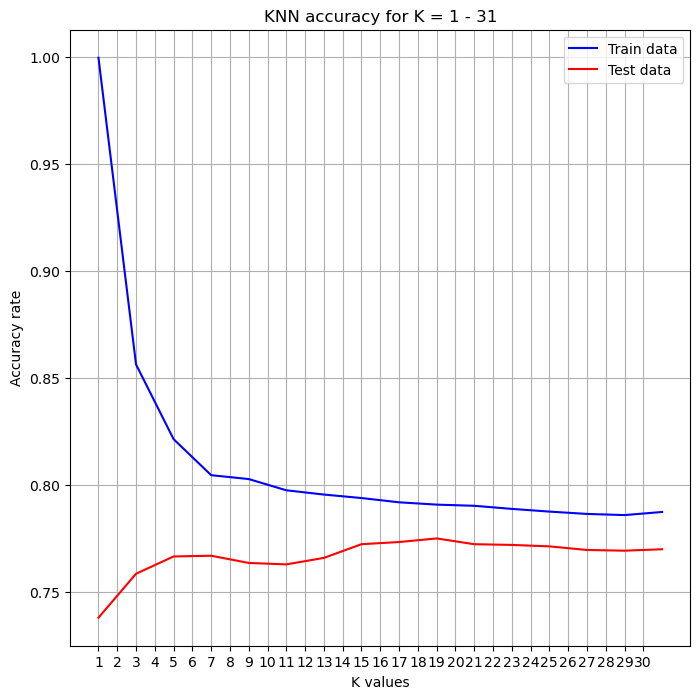

In [12]:
RunAndGraphKNN(Xtrain, Ytrain, Xtest, Ytest, 31)

### As we can see the accuracy for test climbs untill we reach K = 19 in which it peaks.
### After k = 19 we start seeing a trend downwards in accuracy for both sets which indicates that we have found the optimal K number.

# <u>Part 3: Logistic Regression</u>

# Q9: Building the Logistic Regression model 

In [13]:
# Initialize w with w0 = 0 and the rest with 1s
w = np.ones((Xtrain.shape[1] + 1))
w[0] = 0
# Normalize fields where the result can be a big number to prevent extreme outliers(age and bills)
XtrainNormalized = Xtrain.copy()
XtrainNormalized[:,1] /= 10 # Age
XtrainNormalized[:, [3,4,5,6,7,9]] /= 100 # Bills

XtestNormalized = Xtest.copy()
XtestNormalized[:,1] /= 10 # Age
XtestNormalized[:, [3,4,5,6,7,9]] /= 100 # Bills

#### a:

In [14]:
def Sigmoid(w, x): # Using identity 1-σ(z) = σ(-z) to avoid overflow for big exp results
    x_dot_w = np.matmul(w[1:].transpose(), x) + w[0]
    if x_dot_w >= 0:
        z = np.exp(-x_dot_w)
        sigma = 1 / (1 + z)
    else:
        z = np.exp(x_dot_w)
        sigma = z / (1 + z)
    return sigma

In [15]:
def GradientStep(a, w, x, y):
    gradient = 0
    for n in range(x.shape[0]):
        gradient += x[n]*(Sigmoid(w, x[n]) - y[n])
    wNext = np.append(w[0], w[1:] - a*gradient)
    return wNext

#### Run gradient descent T times and return all w iterations

In [16]:
def UpdateW(w, T, a, x, y):
    Wlist = [w]
    for n in range(T):
        w = GradientStep(a, w, x, y)
        Wlist.append(w)
    return np.array(Wlist)

##### Default threshold

In [17]:
defaulthreshold = 0.5
threshold = defaulthreshold

#### Returns probability for each data point (between 0 and 1)

In [18]:
def ProbabilisticLogRegClassifier(w, x):
    P = []
    for n in range(x.shape[0]):
        x_dot_w = w[0] + np.matmul(w[1:].transpose(), x[n])
        if x_dot_w >= 0:
            z = np.exp(-x_dot_w)
            P.append(1 / (1 + z))
        else:
            z = np.exp(x_dot_w)
            P.append(z / (1 + z))
    return np.array(P)

#### Return the final classification for each data point with a given probability threshold

In [19]:
def FinalClassification(P, threshold):
    YpredictedFinal = np.zeros((P.size, ))
    YpredictedFinal[P > threshold] = 1
    return YpredictedFinal

#### Returns the accuracy of the classification

In [20]:
def Accuracy(Ypredicted, Y):
    return np.array(np.where(Y == Ypredicted)).size / Y.size

#### Get accuracy values for all w

In [21]:
def AccuracyVector(w, x, y):
    AccVec = []
    for n in range(w.shape[0]):
        P = ProbabilisticLogRegClassifier(w[n], x)
        Ypredicted = FinalClassification(P, threshold)
        AccVec.append(Accuracy(Ypredicted, y))
    return AccVec

#### Return cross entropy for all w iterations

In [22]:
def Cross_Entropy(w, x, y, threshold):
    CEsum = []
    for n in range(w.shape[0]):
        p = ProbabilisticLogRegClassifier(w[n], x)
        # Avoid log issues
        p[p == 0] = 1e-16
        p[p == 1] = 1 - 1e-16
        yn = FinalClassification(p, threshold)
        CEsum.append(-1*np.sum(y*np.log(p)+(1-y)*np.log(1-p)))
    return CEsum

#### Return confusion matrix

In [23]:
def ConfusionMat(Ypredicted, Y):
    conMat = np.zeros((2, 2))
    for n in range(Ypredicted.size):
        if Y[n] == 0:
            if Ypredicted[n] == 0:
                conMat[1, 1] += 1
            else:
                conMat[0, 1] += 1
        else:
            if Ypredicted[n] == 0:
                conMat[1, 0] += 1
            else:
                conMat[0, 0] += 1
    return conMat

#### Plot confusion matrix

In [24]:
def plotConfusionMatrix(cm):
    plt.figure(figsize=(6, 6))
    plt.title("Confusion Matrix")
    df_cm = pd.DataFrame(cm, index=["Predicted Positive", "Predicted Negative"], columns=["Actual Positive", "Actual Negative"])
    sn.heatmap(df_cm, annot=True, fmt=".0f", cbar=False)
    plt.show()

#### Build and plot the ROC

In [25]:
def ROC(P, Yactual):
    FPR = []
    TPR = []
    # Calculate false positive and true positive rates for different thresholds between 0 and 1
    for threshold in np.linspace(1, 0, 11):
        Ypredicted = FinalClassification(P, threshold)
        cm = ConfusionMat(Ypredicted, Yactual)
        FPR.append(cm[0][1] / (cm[0][1] + cm[1][1]))
        TPR.append(cm[0][0] / (cm[0][0] + cm[1][0]))
    # Plot ROC with the false and true positive rates we calculated
    plt.figure(figsize=(6, 6))
    plt.title('ROC')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.scatter(FPR, TPR, color='b')
    plt.plot(FPR, TPR, color='b')
    plt.grid()
    plt.show()

#### Plot accuracy over T iterations for train data

In [26]:
def plotAccTrain(X, Y):
    AccVec = AccuracyVector(wUpdated, X, Y)
    t = range(1, wUpdated.shape[0]+1)
    plt.figure(figsize=(6, 6))
    plt.title('Accuracy of classification for t times w update for train data')
    plt.xlabel("t values")
    plt.ylabel("Accuracy rate")
    plt.plot(t, AccVec, color='b')
    plt.grid()
    plt.show()

#### Plot accuracy over T iterations for test data

In [27]:
def plotAccTest(X, Y):
    AccVec = AccuracyVector(wUpdated, X, Y)
    t = range(1, wUpdated.shape[0]+1)
    plt.figure(figsize=(6, 6))
    plt.title('Accuracy of classification for t iterations of w update for test data')
    plt.xlabel("t values")
    plt.ylabel("Accuracy rate")
    plt.plot(t, AccVec, color='b')
    plt.grid()
    plt.show()

#### Plot cross entropy loss for train data

In [28]:
def plotCEtrain():
    crossEnt = Cross_Entropy(wUpdated, XtrainNormalized, Ytrain, threshold)
    t = range(1, wUpdated.shape[0]+1)
    plt.figure(figsize=(6, 6))
    plt.title('Cross entropy for train data')
    plt.xlabel("t values")
    plt.ylabel("Cross Entropy Loss")
    plt.plot(t, crossEnt, color='b')
    plt.grid()
    plt.show()

# Choosing α and T for w fit

### first we choose high number for α and low T and see how they affect the accuracy of the classifier
### we observe our results and adjust α and T values to find a good mix of good accuracy and low runtime

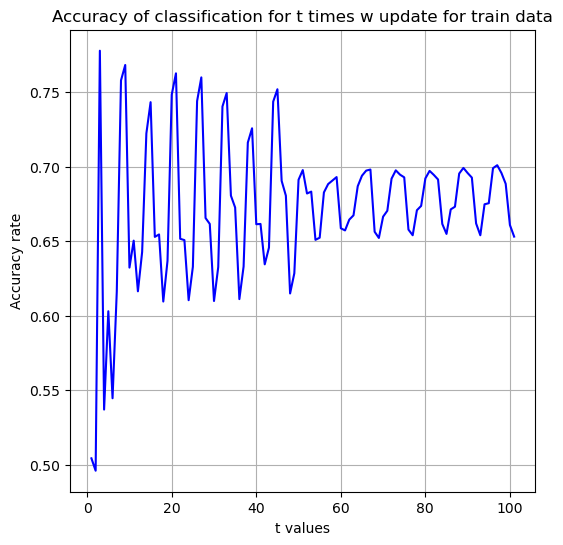

In [29]:
T = 100
a = 1e-3
wUpdated = UpdateW(w, T, a, XtrainNormalized, Ytrain)
plotAccTrain(XtrainNormalized, Ytrain)

### As we can see, accuracy is jumping up and down and not converging, so we choose smaller α and bigger T and try again

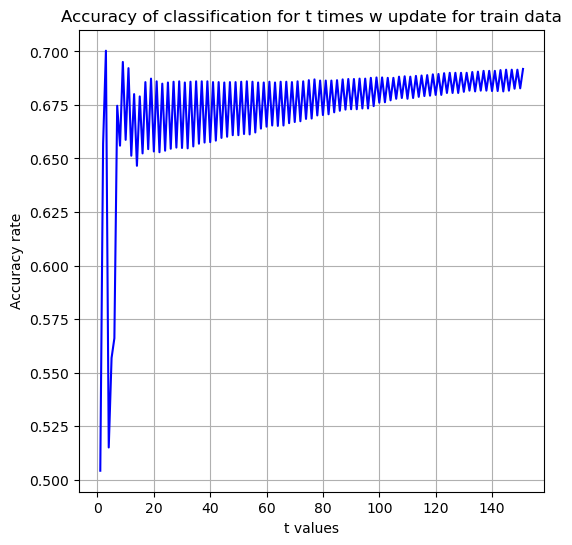

In [30]:
T = 150
a = 1e-4
wUpdated = UpdateW(w, T, a, XtrainNormalized, Ytrain)
plotAccTrain(XtrainNormalized, Ytrain)

### Better results than before but still not converging properly so we try again with a smaller α value

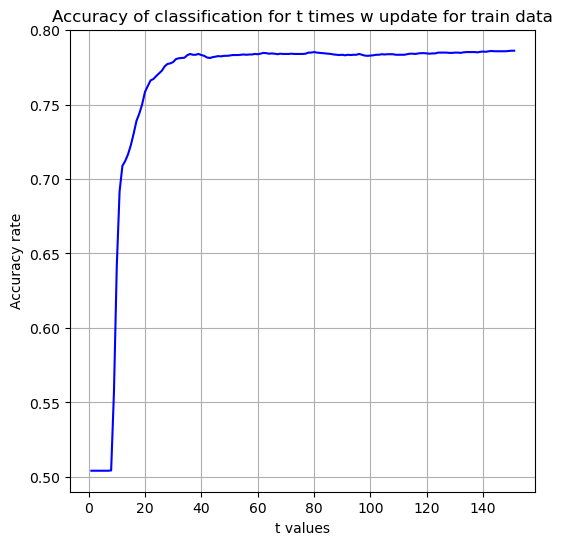

In [31]:
T = 150
a = 1e-5
wUpdated = UpdateW(w, T, a, XtrainNormalized, Ytrain)
plotAccTrain(XtrainNormalized, Ytrain)

### Now we can see that the accuracy went up and is converging to a final value, so we found our α and T values for the training proccess

### a: Plot the CE loss function and accuracy for the train data after the end of w fit

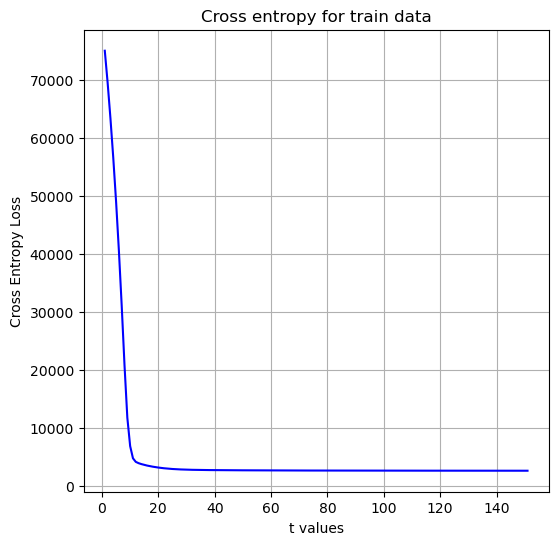

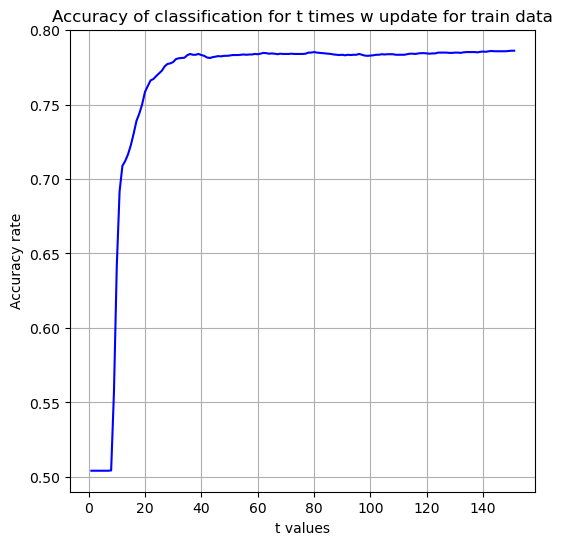

In [32]:
plotCEtrain()
plotAccTrain(XtrainNormalized, Ytrain)

### b: Plot the accuracy for the test data after the end of w fit

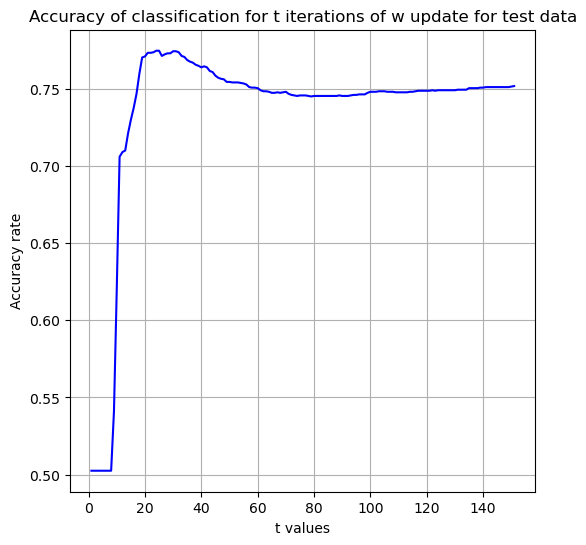

In [33]:
plotAccTest(XtestNormalized, Ytest)

### c: Plot the confusion matrix and ROC for the train data at 3 different points of w

In [34]:
T = wUpdated.shape[0] - 1
halfT = int((T+1)/2)

#### Initial w before fit

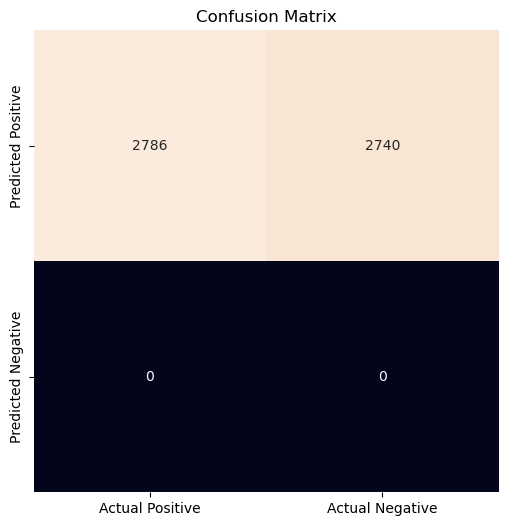

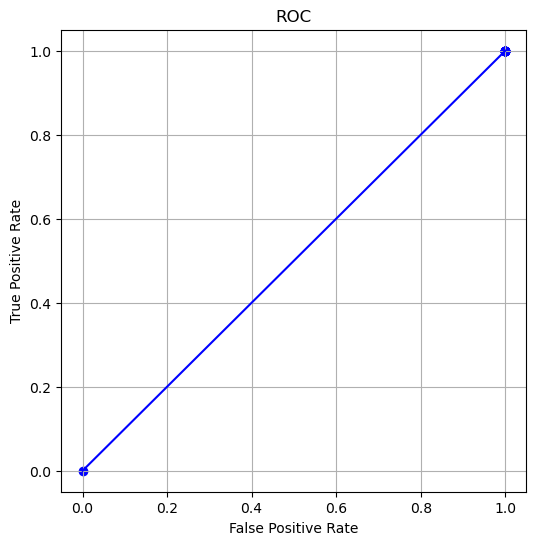

In [35]:
p = ProbabilisticLogRegClassifier(wUpdated[0], XtrainNormalized)
yPredFin = FinalClassification(p, threshold)
cm = ConfusionMat(yPredFin, Ytrain)
plotConfusionMatrix(cm)
ROC(p, Ytrain)

#### w after T/2 iterations

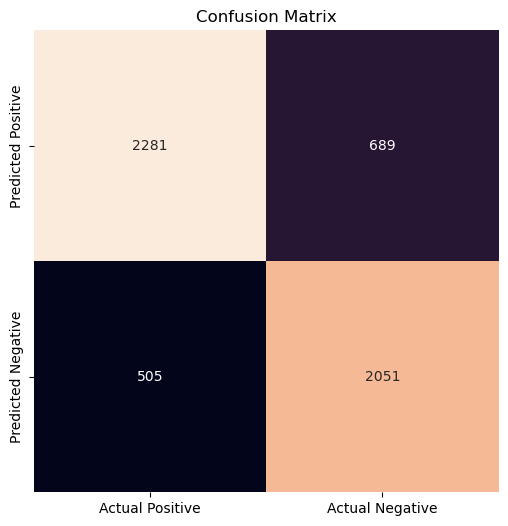

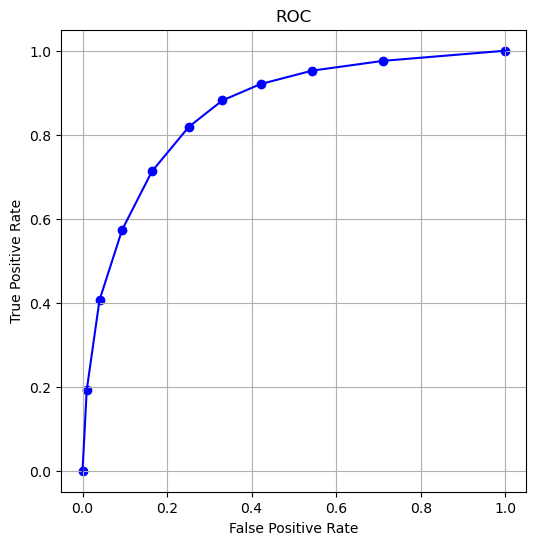

In [36]:
p = ProbabilisticLogRegClassifier(wUpdated[halfT], XtrainNormalized)
yPredFin = FinalClassification(p, threshold)
Accuracy(yPredFin, Ytest)
cm = ConfusionMat(yPredFin, Ytrain)
plotConfusionMatrix(cm)
ROC(p, Ytrain)

#### w after T iterations

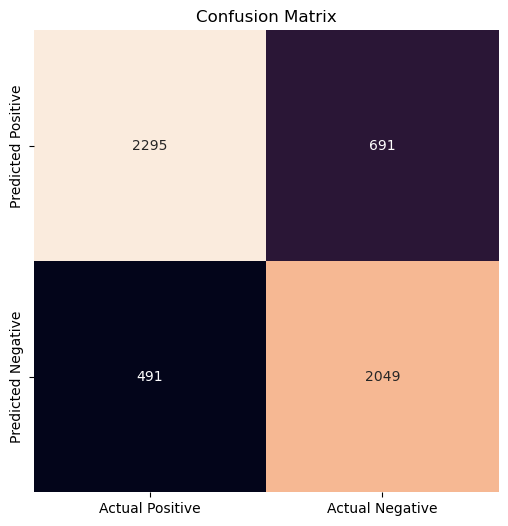

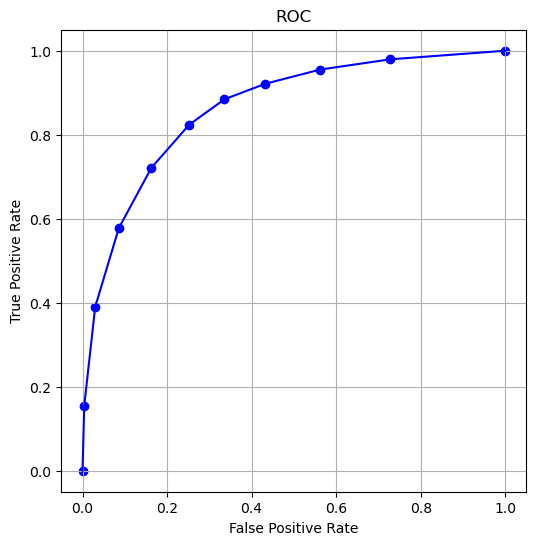

In [37]:
p = ProbabilisticLogRegClassifier(wUpdated[T], XtrainNormalized)
yPredFin = FinalClassification(p, threshold)
cm = ConfusionMat(yPredFin, Ytrain)
plotConfusionMatrix(cm)
ROC(p, Ytrain)

### d: Plot the confusion matrix and ROC for the test data after the end of w fit

#### w after T iterations

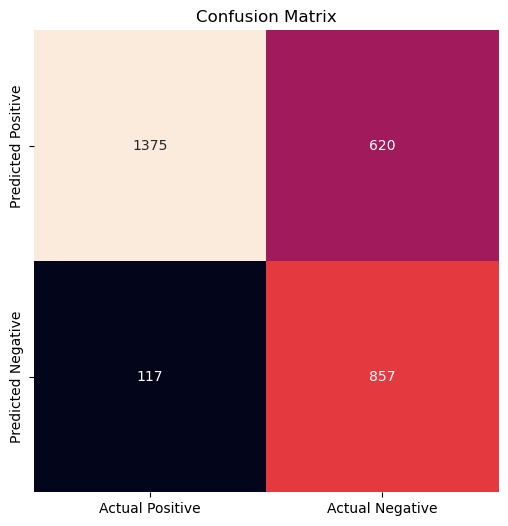

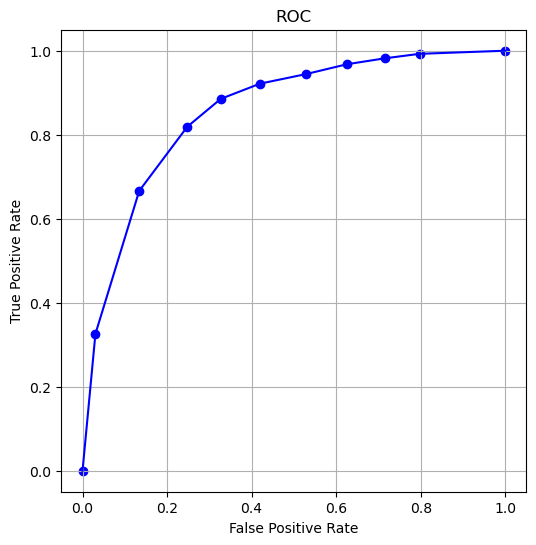

In [38]:
p = ProbabilisticLogRegClassifier(wUpdated[T], XtestNormalized)
yPredFin = FinalClassification(p, threshold)
cm = ConfusionMat(yPredFin, Ytest)
plotConfusionMatrix(cm)
ROC(p, Ytest)

# Q10:

### a: 
#### We demonstrated our selection proccess above with graphs.

### b:
#### w0 was chosen to be 0 to minimize exponent result, the effect w0 has on the training proccess is that the exponent in the sigmoid is only getting w dot x without any bias, choosing a different w0 value could change the result and make the final w to look different even if the accuracy is similar.
#### The effect of α on T is that, with small α steps, we needed to use a bigger T to make sure the gradient descent has enough iterations to make up for smaller steps and arrive at the convergence point.

### c:
#### w0 had the same effect as stated in b.
#### α value had an impact because if the value was too big, the gradient descent couldn't reach its convergence point and w values would be entirely different from the desired results, but too small α could result in an incomplete w that is yet to converge.

### d:
#### We chose to divide the data 2/3 train 1/3 test so the train set isn't too big but it's twice the size of the test data, achieving good results so we didn't divide the test in a different way

### e:
#### We wanted to make sure to avoid overfitting of the data which can occur when the train data is too big and the model is "learning" wrong assumptions based on the way the train data is built but is not necessarily indicative of a general data point.
#### This can result in good accuracy results on the train set but those results are not translating to the test data.
#### We also made sure to avoid underfitting which can lead to the model not "learning" enough and not reaching conclusive decisions, this happens when the train set is too small.

### f:
#### Yes, as we saw in the train loss function graph, the CE is starting high and going down as we continue to train our model untill we reach the lowest loss value we can achieve, this is exactly what we see in the test data as well, accuracy at first is about 0.5, which results in high loss, as we train the model accuracy improves and loss is decreased untill we reach maximum results for the classifier

### g:
#### We normalized some of the data before training the Logistic Regression model. The original data created problems for many Xtrain values that were in some columns extremely high in contrast to other (e.g. ShoppingMall reaching over 6000 while CryoSleep is always 1 or 0) and resulting in unexpected values from the sigmoid exponent. Normalizing the values helped eliminate this issue.

# <u>Part 4: Logistical Regression With Data Normalization</u>

In [39]:
# Normalize X to have Variance = 0 for each column - subtract the average and then divide by the standard deviation
XtrainVarNormalized = (Xtrain - np.mean(Xtrain, axis=0)) / np.std(Xtrain,axis=0)
XtestVarNormalized = (Xtest - np.mean(Xtest, axis=0)) / np.std(Xtest,axis=0)

#### KNN after variance normalization

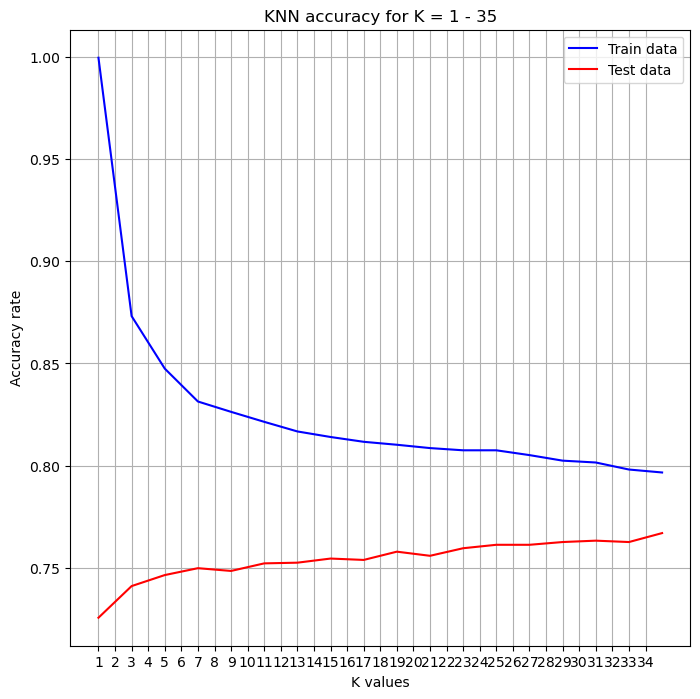

In [40]:
RunAndGraphKNN(XtrainVarNormalized, Ytrain, XtestVarNormalized, Ytest, 35)

#### Logistic Regression after variance normalization

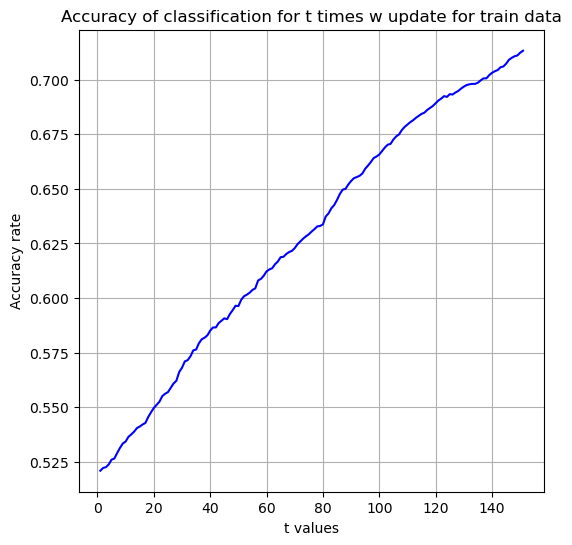

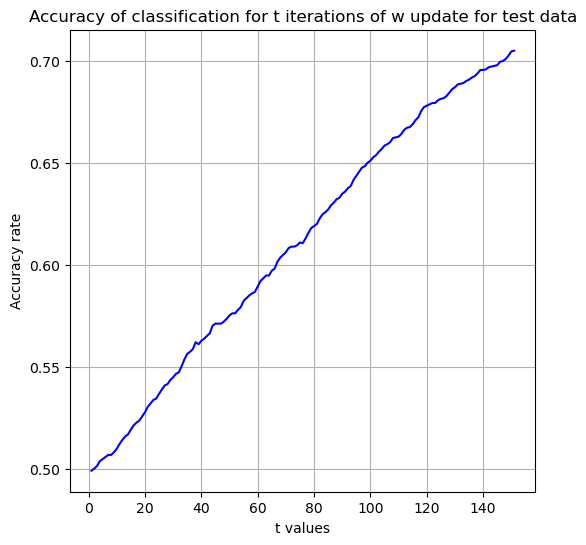

In [41]:
T = 150
a = 1e-5
wUpdated = UpdateW(w, T, a, XtrainVarNormalized, Ytrain)
plotAccTrain(XtrainVarNormalized, Ytrain)
plotAccTest(XtestVarNormalized, Ytest)

#### As we can see, the step is now too small so we increase the step and lower T

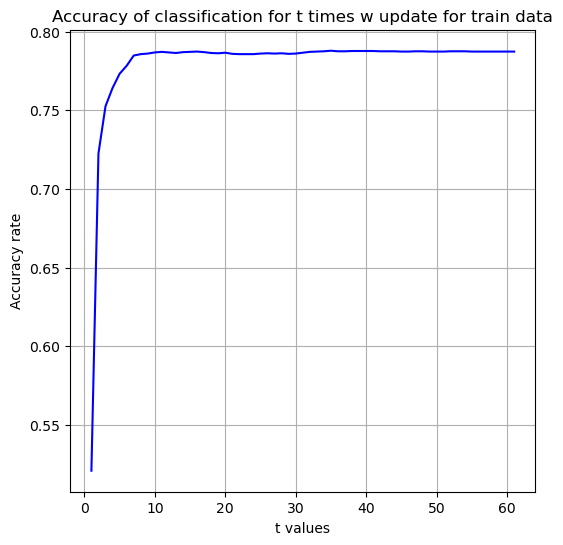

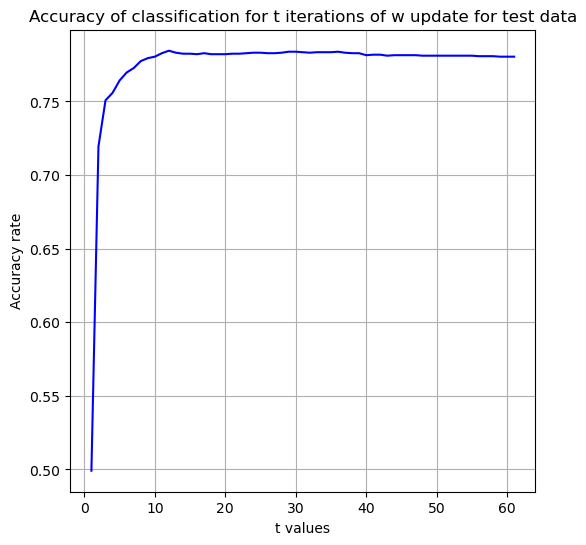

In [42]:
T = 60
a = 1e-3
wUpdated = UpdateW(w, T, a, XtrainVarNormalized, Ytrain)
plotAccTrain(XtrainVarNormalized, Ytrain)
plotAccTest(XtestVarNormalized, Ytest)

#### The difference in the KNN model is as we can see, the convergence for the Variance normalized results takes longer but the graph is showing a more steady climb over the K values.
#### In the Logistic Regression model, normalizing the data by variance made the gradient descent to converge a lot easier than before, taking a bigger step and with a much smaller T value to achieve even better accuracy results on the test data than before.